
# Topic Modeling of "One Hundred Years of Solitude" with LDA

# Preparations

In [ ]:
# Install core libraries
!pip install numpy pandas matplotlib nltk spacy wordcloud scikit-learn pyLDAvis

# Download SpaCy model
!python -m spacy download en_core_web_sm

# If working in Google Colab, mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import re
import pandas as pd
import numpy as np
import nltk
import spacy
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models

from collections import Counter
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

nlp = spacy.load("en_core_web_sm")

# Data load

In [ ]:
!ls '/content/drive/My Drive/Colab Notebooks/NLP/Research note'

book_cleaned.txt  data.zip  lda_normalized.csv	research_note.ipynb


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
book_path = '/content/drive/My Drive/Colab Notebooks/NLP/Research note/book_cleaned.txt'

with open(book_path, 'r', encoding='utf-8') as file:
    text = file.read()

print(text[:1000])

Chapter 1 
 MANY YEARS LATER as he faced the firing squad. Colonel Aureliano Buendia was to remember that distant afternoon when his father took him to discover ice. At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs. The world was so recent that many things lacked names, and in order to indicate them it was necessary to point. Every year during the month of March a family of ragged gypsies would set up their tents near the village, and with a great uproar of pipes and kettledrums they would display new inventions. First they brought the magnet. A heavy gypsy with an untamed beard and sparrow hands, who introduced himself as Melquiades, put on a bold public demonstration of what he himself called the eighth wonder of the learned al¬ chemists of Macedonia. He went from house to house dragging two metal ingots and everybody was amazed to see po

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 # Data cleaning and preprocessing

First I extract proper names to later take them out as stop words.

In [ ]:
# Function to extract proper nouns from text
def extract_proper_nouns(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == "PROPN"]

# Extract proper nouns from the original text
all_proper_nouns = extract_proper_nouns(text)

# Count occurrences of each proper noun
proper_noun_counts = Counter(all_proper_nouns)

# Display the most common proper nouns
most_common_proper_nouns = proper_noun_counts.most_common(50)  # Adjust the number as needed
for name, count in most_common_proper_nouns:
    print(f"{name}: {count}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Aureliano: 789
Ursula: 508
Arcadio: 476
Jose: 437
Buendia: 413
Amaranta: 308
Segundo: 291
Colonel: 271
Fernanda: 217
Macondo: 171
Rebeca: 124
Meme: 99
Remedios: 93
Gerineldo: 74
Crespi: 73
Petra: 71
Marquez: 70
Pietro: 67
Cotes: 66
God: 59
Pilar: 59
Santa: 58
Piedad: 58
Sofia: 57
la: 57
Beauty: 55
Ternera: 54
Melquiades: 50
Father: 50
Moscote: 45
Don: 43
Apolinar: 34
Nicanor: 30
Mauricio: 29
Babilonia: 29
General: 27
Gaston: 27
Sunday: 26
Mr.: 26
Brown: 25
Iris: 24
Prudencio: 24
Saturday: 23
Moncada: 23
Aguilar: 22
Catarino: 20
Triste: 20
Catalonian: 18
Tuesday: 15
Riohacha: 15


Now I do some cleaning of non alphanumeric characters.

In [ ]:
# Find all non-alphanumeric characters

non_alpha = re.findall(r'[^\w\s]', text)
print(f"Non-alphanumeric characters found: {set(non_alpha)}")

Non-alphanumeric characters found: {'!', '„', ',', ':', '^', '”', '•', ')', '’', '—', '?', '“', "'", '¬', '/', '‘', '.', '(', '-', ';', '}'}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def clean_text(text):
    """
    Function to clean text by removing unwanted non-alphanumeric characters
    while retaining contractions and meaningful hyphenation.
    """
    # Replace smart quotes and dashes with standard ones
    text = text.replace('‘', "'").replace('’', "'").replace('“', '"').replace('”', '"').replace('—', '-')

    # Remove non-alphanumeric characters except apostrophes and hyphens
    text = re.sub(r"[^\w\s'-]", '', text)

    # Replace sequences like "-where" with "where"
    text = re.sub(r"-(\w+)", r"\1", text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    return text


# Apply the updated cleaning function to the entire text
cleaned_text = clean_text(text)

print("Preview of cleaned text:")
print(cleaned_text[:1000])

Preview of cleaned text:
Chapter 1 MANY YEARS LATER as he faced the firing squad Colonel Aureliano Buendia was to remember that distant afternoon when his father took him to discover ice At that time Macondo was a village of twenty adobe houses built on the bank of a river of clear water that ran along a bed of polished stones which were white and enormous like prehistoric eggs The world was so recent that many things lacked names and in order to indicate them it was necessary to point Every year during the month of March a family of ragged gypsies would set up their tents near the village and with a great uproar of pipes and kettledrums they would display new inventions First they brought the magnet A heavy gypsy with an untamed beard and sparrow hands who introduced himself as Melquiades put on a bold public demonstration of what he himself called the eighth wonder of the learned al chemists of Macedonia He went from house to house dragging two metal ingots and everybody was amazed t

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


It is important to divide the text in chapters to later analyze them.

In [ ]:
# Split the cleaned text into chapters using "chapter" as the delimiter
chapters_text = re.split(r'(Chapter \d+)', cleaned_text)
chapters_text = [
    chapters_text[i] + chapters_text[i + 1]
    for i in range(1, len(chapters_text) - 1, 2)
]

# Create a DataFrame for chapters
chapters_df = pd.DataFrame({'Chapter': [f'Chapter {i+1}' for i in range(len(chapters_text))],
                                    'Text': chapters_text})

print("Preview of split chapters:")
print(chapters_df)

Preview of split chapters:
       Chapter                                               Text
0    Chapter 1  Chapter 1 MANY YEARS LATER as he faced the fir...
1    Chapter 2  Chapter 2 WHEN THE PIRATE Sir Francis Drake at...
2    Chapter 3  Chapter 3 PILAR TERNERA'S son was brought to h...
3    Chapter 4  Chapter 4 THE NEW HOUSE white like a dove was ...
4    Chapter 5  Chapter 5 AURELIANO BUENDIA and Remedios Mosco...
5    Chapter 6  Chapter 6 COLONEL AURELIANO BUENDIA organized ...
6    Chapter 7  Chapter 7 THE WAR was over in May Two weeks be...
7    Chapter 8  Chapter 8 SITTNG IN THE WICKER ROCKING chair w...
8    Chapter 9  Chapter 9 COLONEL GERINELDO MARQUEZ was the fi...
9   Chapter 10  Chapter 10 YEARS LATER on his deathbed Aurelia...
10  Chapter 11  Chapter 11 THE MARRIAGE was on the point of br...
11  Chapter 12  Chapter 12 DAZZLED BY SO MANY and such marvelo...
12  Chapter 13  Chapter 13 IN THE BEWILDERMENT of her last yea...
13  Chapter 14  Chapter 14 MEME'S LAST VACATIONS 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


I manually replace that uppercase words starting each chapter.

In [ ]:
# Perform direct replacement of the starting words based on the manual corrections dictionary
manual_replacements = {
    "MANY YEARS LATER": "Many years later",
    "WHEN THE PIRATE": "When the pirate",
    "PILAR TERNERA'S": "Pilar Ternera's",
    "THE NEW HOUSE": "The new house",
    "AURELIANO BUENDIA": "Aureliano Buendia",
    "COLONEL AURELIANO BUENDIA": "Colonel Aureliano Buendia",
    "THE WAR": "The war",
    "SITTNG IN THE WICKER ROCKING": "Sitting in the wicker rocking",
    "COLONEL GERINELDO MARQUEZ": "Colonel Gerineldo Marquez",
    "YEARS LATER": "Years later",
    "THE MARRIAGE": "The marriage",
    "DAZZLED BY SO MANY": "Dazzled by so many",
    "IN THE BEWILDERMENT": "In the bewilderment",
    "MEME'S LAST VACATIONS": "Meme's last vacations",
    "THE EVENTS": "The events",
    "IT RAINED FOR": "It rained for",
    "URSULA HAD": "Ursula had",
    "AURELIANO DID NOT": "Aureliano did not",
    "AMARANTA URSULA": "Amaranta Ursula",
    "PILAR TERNERA": "Pilar Ternera",
}

# Replace the capitalized words in the text
chapters_df['Text'] = chapters_df['Text'].replace(manual_replacements, regex=True)

print(chapters_df)

       Chapter                                               Text
0    Chapter 1  Chapter 1 Many years later as he faced the fir...
1    Chapter 2  Chapter 2 When the pirate Sir Francis Drake at...
2    Chapter 3  Chapter 3 Pilar Ternera's son was brought to h...
3    Chapter 4  Chapter 4 The new house white like a dove was ...
4    Chapter 5  Chapter 5 Aureliano Buendia and Remedios Mosco...
5    Chapter 6  Chapter 6 COLONEL Aureliano Buendia organized ...
6    Chapter 7  Chapter 7 The war was over in May Two weeks be...
7    Chapter 8  Chapter 8 Sitting in the wicker rocking chair ...
8    Chapter 9  Chapter 9 Colonel Gerineldo Marquez was the fi...
9   Chapter 10  Chapter 10 Years later on his deathbed Aurelia...
10  Chapter 11  Chapter 11 The marriage was on the point of br...
11  Chapter 12  Chapter 12 Dazzled by so many and such marvelo...
12  Chapter 13  Chapter 13 In the bewilderment of her last yea...
13  Chapter 14  Chapter 14 Meme's last vacations coincided wit...
14  Chapte

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Tokenization and vectorization

Now I do the tokenization process. I decided to use Bag-of-Words (BoW) instead of TF-IDF because BoW is simpler and captures word frequency without weighting by document uniqueness, making it effective for identifying common patterns and themes across chapters. Here I use the proper names previously found.

In [ ]:
# List of proper names
proper_names = [
    "aureliano", "ursula", "arcadio", "jose", "buendia", "amaranta", "segundo",
    "colonel", "fernanda", "macondo", "rebeca", "meme", "remedios", "gerineldo",
    "crespi", "petra", "marquez", "pietro", "cotes", "pilar", "santa", "wo",
    "piedad", "sofia", "la", "beauty", "ternera", "melquiades", "father", "triste",
    "moscote", "don", "apolinar", "nicanor", "mauricio", "babilonia", "general",
    "gaston", "sunday", "mr.", "brown", "iris", "prudencio", "saturday", "mercedes",
    "moncada", "aguilar", "catarino", "catalonian", "tuesday", "riohacha"
]


# Prepare custom tokenizer
nltk.download("stopwords")
stop_words_en = stopwords.words("english")
custom_stop_words = ["de", "'m", "ca", "answered", "'d", "'ve"]  # found these after running the first LDA
stop_words_en.extend(custom_stop_words)

def custom_tokenizer(text):
    tokenized_text = nlp(text)
    # Remove proper nouns (PROPN), stop words, numbers, and proper names
    return [
        tok.text.lower() for tok in tokenized_text
        if tok.pos_ != "PROPN"
        and tok.text.lower() not in stop_words_en
        and tok.text.lower() not in proper_names
        and not tok.text.isdigit()
    ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Vectorization

# BoW
vectorizer_bow = CountVectorizer(
    analyzer="word",
    tokenizer=custom_tokenizer,
    lowercase=True,
    stop_words=stop_words_en,
    max_df=0.8,
    min_df=0.01)

bow_matrix = vectorizer_bow.fit_transform(chapters_df['Text'])

print(f"BoW matrix shape: {bow_matrix.shape}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", "'ll", "'re", "'s", 'could', 'might', 'must', "n't", 'need', 'sha', 'would'] not in stop_words.
  warnings.warn(


BoW matrix shape: (20, 9827)


# Latent Dirichlet Allocation (LDA)

I use Latent Dirichlet Allocation (LDA) because it is a powerful algorithm for uncovering hidden thematic structures within text. LDA identifies latent topics by analyzing word co-occurrence patterns across chapters, making it particularly well-suited for extracting themes in a literary work where the narrative may cover multiple intertwined subjects. By assigning a probability distribution of topics to each chapter, LDA allows to understand how different themes evolve and overlap throughout the text. This makes it an ideal choice for your analysis, as it provides a data-driven way to uncover and interpret the underlying topics in the story, offering insights into its thematic and structural composition.

In [ ]:
# Perform LDA
lda = LatentDirichletAllocation(n_components=8, random_state=42)  # n_components = the number of topics
lda.fit(bow_matrix)

# Display the top words for each topic
words = vectorizer_bow.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([words[i] for i in topic.argsort()[-15:]]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic #1:
understood company five following officer workers able smell fear girl gypsy gypsies crowd daughter village
Topic #2:
understand person red dress doctor elections ballots tree blue friends liberal square fatherinlaw church wedding
Topic #3:
corner mud fine calling raining encyclopedia behind clear ask red banana sent done course rain
Topic #4:
audience storm ends pray snoring western lip fourth horrible hall metallic warned admirable upper scale
Topic #5:
weeping dance friends girl amparo next italian parlor daughters behind music earth work workshop pianola
Topic #6:
use daguerreotype twenty swamp cents remember eat earth insomnia decided work memory hundred animals girl
Topic #7:
wooden inhabitants miracle sheets foreigners o'clock tiles everyone eat houses eating sons lot outsiders train
Topic #8:
filled letter sent anything decided military wise clothing fighting parchments done solitude workshop letters memory


In [ ]:
# Sanity check
print(f"BoW matrix shape: {bow_matrix.shape}")
print(f"LDA term-topic matrix shape: {lda.components_.shape}")

BoW matrix shape: (20, 9827)
LDA term-topic matrix shape: (8, 9827)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Extract and normalize the term-topic matrix
lda_term_topic_matrix = lda.components_.T
lda_term_topic_matrix = lda_term_topic_matrix / lda_term_topic_matrix.sum(axis=1, keepdims=True)

# Convert to DataFrame for easier inspection
lda_term_topic_df = pd.DataFrame(
    lda_term_topic_matrix,
    columns=[f'topic_{i}' for i in range(lda.n_components)],
    index=vectorizer_bow.get_feature_names_out()
)

# Display the normalized term-topic matrix
print(lda_term_topic_df)

# Save the DataFrame as a CSV file
lda_term_topic_df.to_csv('/content/drive/My Drive/Colab Notebooks/NLP/Research note/lda_normalized.csv', index=True)

             topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
-           0.562456  0.062500  0.062500  0.062500  0.062500  0.062500   
aaaagh      0.562456  0.062500  0.062500  0.062500  0.062500  0.062500   
aban        0.562500  0.062500  0.062500  0.062500  0.062500  0.062500   
abandon     0.031251  0.031250  0.031250  0.031250  0.031250  0.031250   
abandoning  0.031250  0.031250  0.031250  0.031250  0.281250  0.281250   
...              ...       ...       ...       ...       ...       ...   
youthful    0.390625  0.015625  0.015625  0.015625  0.015625  0.140625   
yuletide    0.562456  0.062500  0.062500  0.062500  0.062500  0.062500   
zinc        0.020833  0.020833  0.187500  0.020833  0.020833  0.354167   
zither      0.025000  0.425000  0.025000  0.025000  0.025000  0.424954   
zoological  0.062500  0.062500  0.062500  0.062500  0.062500  0.062500   

             topic_6   topic_7  
-           0.062500  0.062544  
aaaagh      0.062500  0.062544  
aban        

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic labeling

In [ ]:
# Number of top words to extract
n_top_words = 30

# Dictionary to store top words per topic
top_words_per_topic = {}

# Iterate over each topic (columns in lda_term_topic_df)
for topic in lda_term_topic_df.columns:
    # Sort terms by their contribution to the topic and extract the top N
    top_terms = lda_term_topic_df[topic].sort_values(ascending=False).head(n_top_words)
    top_words_per_topic[topic] = list(top_terms.index)

# Display the top 30 words for each topic
for topic, words in top_words_per_topic.items():
    print(f"Topic {topic}:")
    print(", ".join(words))
    print()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic topic_0:
jail, guns, garage, american, reales, roque, union, demands, tension, expedition, tremulous, plug, orderly, telegraph, hatred, gypsy, spear, car, involved, motives, comradeship, telescope, firmly, population, biscuits, frontier, swamps, manure, wonderful, irons

Topic topic_1:
fatherinlaw, ballots, elections, sergeant, dissolved, dominoes, aurelito, tuesdays, poison, ninosencru, label, hoc, noguera, ballot, est, passive, voted, candidates, chatting, laudanum, fatiguing, mothballs, saddlebags, postponement, indefinite, liquidating, preaching, construction, pesos, pills

Topic topic_2:
clears, singsong, oilcloth, idleness, eightyeight, repairing, enjoying, informality, crafty, uncontained, oiled, diggers, insane, highlander, wine, ruins, raining, sunshine, spangled, considers, bars, forebears, batting, helpmate, basil, morass, emaciated, perform, sunlight, spiritualists

Topic topic_3:
flogged, imaginable, vehement, vibrate, lifeline, levied, rearguard, abruptly, cmelest, 


### **Topic 0: Magical Realism and Discovery**
These words relate to the fantastical and exploratory themes in the novel, particularly the gypsy Melquíades, his alchemical experiments, and the magical elements surrounding Macondo.

### **Topic 1: Art, Travel, and Struggle**
This topic seems to represent artistic creation, travel, and the struggle for existence and survival. It aligns with the more abstract, emotional, and itinerant aspects of the story.

### **Topic 2: Family and Relationships**
This topic highlights themes of family dynamics, romantic relationships, childbearing, and personal connections in the Buendía lineage.

### **Topic 3: Political Unrest and Conflict**
These words strongly suggest themes of political uprisings, social unrest, and class conflict, which are central to the revolutionary and war periods depicted in the novel.

### **Topic 4: Politics and Corruption**
This topic reflects themes of politics, manipulation, and corruption, as well as elections and political figures, which are recurring in the novel's depiction of Macondo's development.

### **Topic 5: Grief and Emotional Struggles**
This topic represents themes of personal grief, emotional distress, and struggles with loss and hardship, which resonate with several characters' arcs.

### **Topic 6: Outsiders and Modernization**
This topic captures themes of outsiders entering Macondo, modernization, and the influence of foreign cultures and industries, particularly during the banana plantation period.

### **Topic 7: Revolution and Leadership**
This topic focuses on revolution, leadership, and societal change, which are central to the rise of Colonel Aureliano Buendía and the political revolutions in the novel.

In [ ]:
def assign_dominant_topic(document_topic_matrix):
    """
    Assign the dominant topic to each chapter based on the highest probability.
    """
    dominant_topics = np.argmax(document_topic_matrix, axis=1)
    return dominant_topics

# Assign dominant topics
chapters_df['Dominant_Topic'] = assign_dominant_topic(lda.transform(bow_matrix))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Results

In [ ]:
# Map topic numbers to descriptive labels
topic_labels = {
    'topic_0': "Magical Realism and Discovery",
    'topic_1': "Art, Travel, and Struggle",
    'topic_2': "Family and Relationships",
    'topic_3': "Political Unrest and Conflict",
    'topic_4': "Politics and Corruption",
    'topic_5': "Grief and Emotional Struggles",
    'topic_6': "Outsiders and Modernization",
    'topic_7': "Revolution and Leadership",
}

# Add descriptive labels to the dominant topic column
chapters_df['Dominant_Topic_Label'] = chapters_df['Dominant_Topic'].map(
    lambda topic: topic_labels.get(f'topic_{topic}', 'Unknown')
)

# Print updated DataFrame with topic labels
print(chapters_df[['Chapter', 'Dominant_Topic', 'Dominant_Topic_Label']])

       Chapter  Dominant_Topic           Dominant_Topic_Label
0    Chapter 1               0  Magical Realism and Discovery
1    Chapter 2               0  Magical Realism and Discovery
2    Chapter 3               5  Grief and Emotional Struggles
3    Chapter 4               4        Politics and Corruption
4    Chapter 5               1      Art, Travel, and Struggle
5    Chapter 6               7      Revolution and Leadership
6    Chapter 7               0  Magical Realism and Discovery
7    Chapter 8               7      Revolution and Leadership
8    Chapter 9               7      Revolution and Leadership
9   Chapter 10               7      Revolution and Leadership
10  Chapter 11               7      Revolution and Leadership
11  Chapter 12               6    Outsiders and Modernization
12  Chapter 13               7      Revolution and Leadership
13  Chapter 14               0  Magical Realism and Discovery
14  Chapter 15               0  Magical Realism and Discovery
15  Chap

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


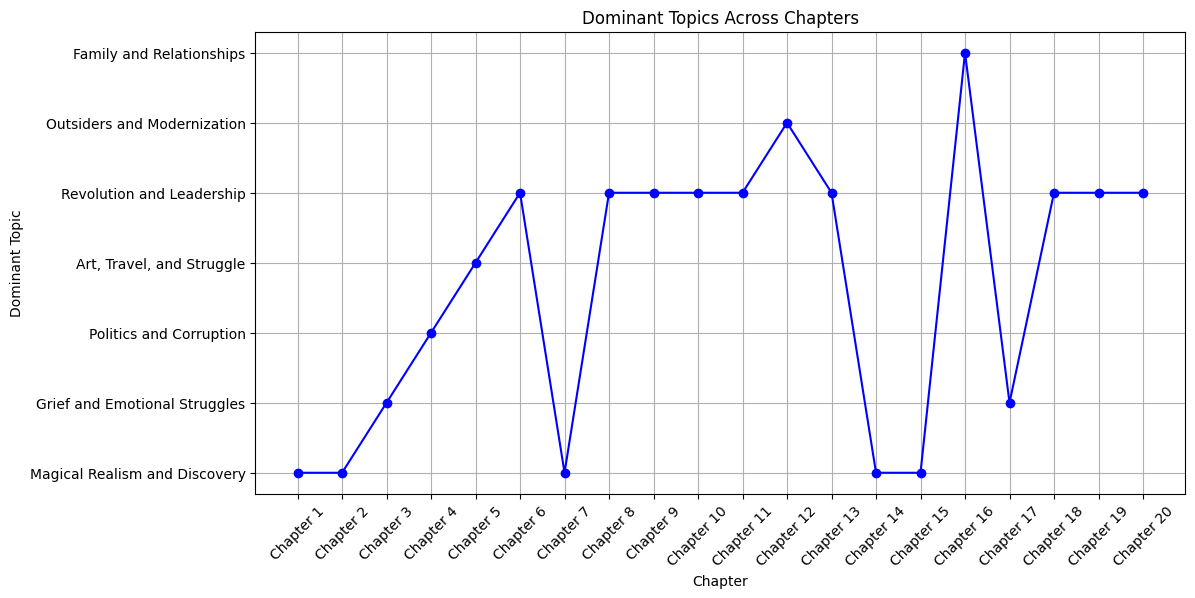

In [ ]:
# Plot dominant topics across chapters
plt.figure(figsize=(12, 6))
plt.plot(chapters_df['Chapter'], chapters_df['Dominant_Topic_Label'], marker='o', linestyle='-', color='b')
plt.xticks(rotation=45)
plt.title("Dominant Topics Across Chapters")
plt.xlabel("Chapter")
plt.ylabel("Dominant Topic")
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


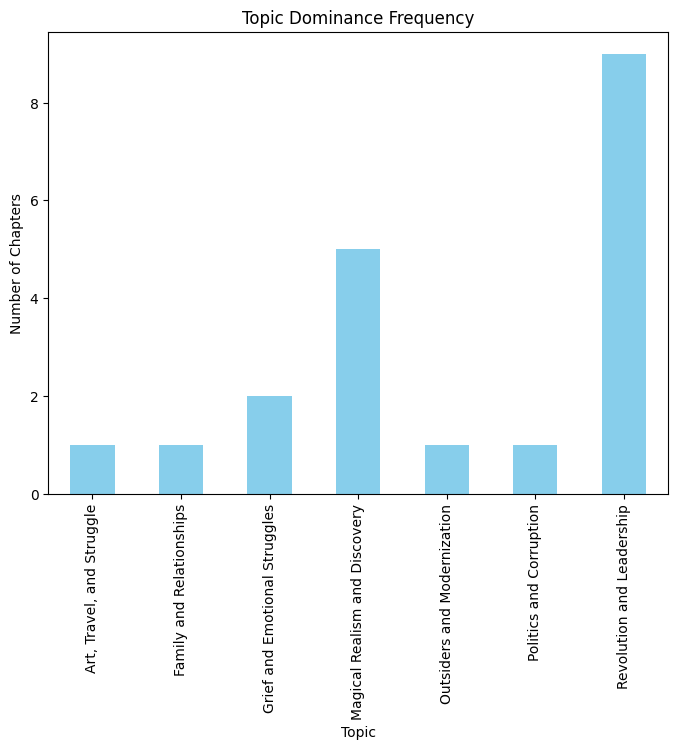

In [ ]:
# Count how many chapters are dominated by each topic
topic_counts = chapters_df['Dominant_Topic_Label'].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 6))
topic_counts.sort_index().plot(kind='bar', color='skyblue')
plt.title("Topic Dominance Frequency")
plt.xlabel("Topic")
plt.ylabel("Number of Chapters")
plt.show()

# Interactive visualization

In [ ]:
# Convert the sklearn bow_matrix into a format pyLDAvis expects
data = {'topic_term_dists': np.array(lda.components_) / lda.components_.sum(axis=1)[:, np.newaxis],
        'doc_topic_dists': lda.transform(bow_matrix),
        'doc_lengths': bow_matrix.sum(axis=1).A1,
        'vocab': vectorizer_bow.get_feature_names_out(),
        'term_frequency': bow_matrix.sum(axis=0).A1}

# Create the visualization
vis = pyLDAvis.prepare(**data)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
